In [4]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda, serializers
import chainer.functions as F
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net, MLP

In [5]:
n_epoch = 3 #エポック
batchsize = 3000 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 20 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = False #GPUを使うかどうか

In [6]:
xp = cuda.cupy if use_gpu is True else np

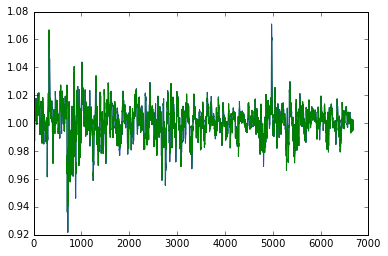

In [7]:
raw_data = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    raw_data.append(row[7])
raw_data = np.asarray(raw_data, dtype=np.float32)
data_x = raw_data[:-1]
data_y = raw_data[1:]
train_data_x, test_data_x = data_x[:int(len(data_x) * 0.8)], data_x[:int(len(data_x) * 0.2)]
train_data_y, test_data_y = data_y[:int(len(data_y) * 0.8)], data_y[:int(len(data_y) * 0.2)]

plt.plot(train_data_x)
plt.plot(train_data_y)

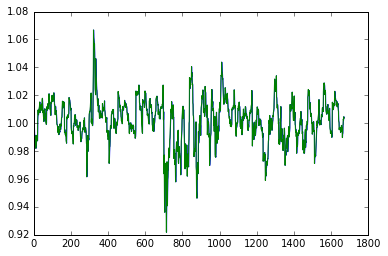

In [8]:
plt.plot(test_data_x)
plt.plot(test_data_y)

In [9]:
#ネットワークを試す関数
def evaluate(model, x, y):
    evaluator = model.copy()
    evaluator.reset_state()
    out = evaluator.predict(chainer.Variable(xp.asarray([[x_] for x_ in x])))
    error = F.mean_squared_error(out, chainer.Variable(xp.asarray([[y] for y in y], dtype=np.float32)))
    return chainer.cuda.to_cpu(out.data), error.data

In [10]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
test_loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 2000 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data * len(x) / length))
        #loss.append(loss_data * batchsize / length)
        
        loss.append(evaluate(model, train_data_x, train_data_y)[1])
        test_loss.append(evaluate(model, test_data_x, test_data_y)[1])
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

In [11]:
#モデルを保存
serializers.save_npz('my.model', model)

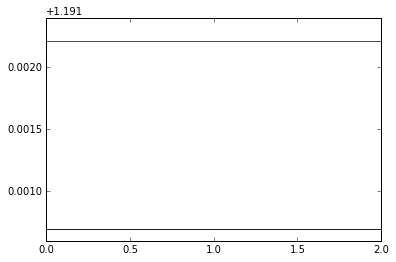

In [12]:
plt.plot(loss[-6000:])
plt.plot(test_loss[-6000:])

In [13]:
output, error = evaluate(model, train_data_x, train_data_y)

print(error)

1.1916955709457397


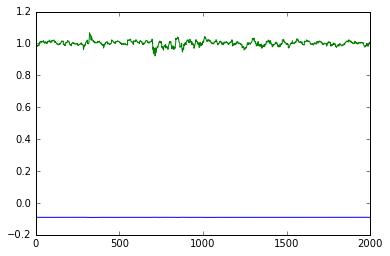

In [14]:
plt.plot(output[:2000])
plt.plot(train_data_y[:2000])

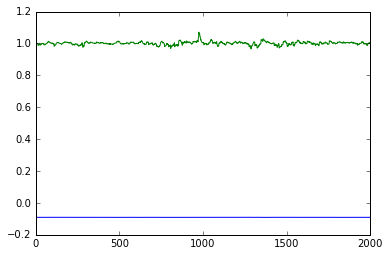

In [15]:
plt.plot(output[4000:6000])
plt.plot(train_data_y[4000:6000])

In [16]:
output, error = evaluate(model, test_data_x, test_data_y)
print('test error = {}'.format(error))

test error = 1.1932092905044556


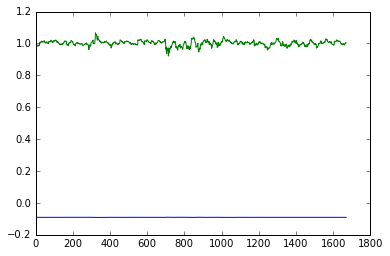

In [17]:
plt.plot(output)
plt.plot(test_data_y)